# Explicabilidad y Diagnóstico

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import shap

/Users/titusr09/Downloads/DataMiningProyectoFinal/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cargar dataset
df = pd.read_csv('../data/processed/modeling_dataset.csv')
df['fecha_primera_sesion'] = pd.to_datetime(df['fecha_primera_sesion'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   uid                                   36523 non-null  uint64        
 1   n_compras                             36523 non-null  int64         
 2   revenue_total                         36523 non-null  float64       
 3   aov                                   36523 non-null  float64       
 4   fecha_primera_compra                  36523 non-null  object        
 5   fecha_ultima_compra                   36523 non-null  object        
 6   dias_entre_compras                    36523 non-null  int64         
 7   is_retained                           36523 non-null  int64         
 8   meses_activo                          36523 non-null  float64       
 9   gasto_mensual_promedio                36523 non-null  float64       
 10

In [12]:
df.head()

,uid,n_compras,revenue_total,aov,fecha_primera_compra,fecha_ultima_compra,dias_entre_compras,is_retained,meses_activo,gasto_mensual_promedio,...,primer_dispositivo,primer_source,n_sesiones,CAC_source_30,cohort_year,cohort_month,duracion_promedio_sesion,n_dispositivos_distintos,dias_activo,LTV_180
0,313578113262317,1,0.55,0.550,2018-01-03 21:51:00,2018-01-03 21:51:00,0,0,1.0,0.55,...,0,2,3,0.340746,2017,9,660.0,1,173,0.55
1,1575281904278712,2,3.05,1.525,2017-06-03 10:13:00,2017-06-03 17:39:00,0,0,1.0,3.05,...,1,10,2,0.184264,2017,6,480.0,1,0,3.05
2,2429014661409475,1,73.33,73.330,2017-10-11 18:33:00,2017-10-11 18:33:00,0,0,1.0,73.33,...,0,3,1,0.571038,2017,10,780.0,1,0,73.33
3,2464366381792757,1,2.44,2.440,2018-01-28 15:54:00,2018-01-28 15:54:00,0,0,1.0,2.44,...,0,5,2,0.264780,2018,1,450.0,1,0,2.44
4,2551852515556206,2,10.99,5.495,2017-11-24 10:14:00,2017-11-24 11:24:00,0,0,1.0,10.99,...,0,5,2,0.264780,2017,11,279.5,1,0,10.99


In [10]:
# Eliminar filas con nulos en la columna target
df = df.dropna(subset=['LTV_180'])

In [13]:
columnas_excluir = [
    'LTV_180',
    'fecha_primera_sesion',
    'uid',
    'fecha_primera_compra',
    'fecha_ultima_compra'
]

In [14]:
def dividir_dataset(df, fecha_col='fecha_primera_sesion'):
    fecha_val_inicio = pd.Timestamp('2018-01-01')
    fecha_val_fin = pd.Timestamp('2018-06-30')
    fecha_test_inicio = pd.Timestamp('2018-07-01')
    fecha_test_fin = pd.Timestamp('2018-12-31')

    df_train = df[df[fecha_col] < fecha_val_inicio]
    df_val = df[(df[fecha_col] >= fecha_val_inicio) & (df[fecha_col] <= fecha_val_fin)]
    df_test = df[(df[fecha_col] >= fecha_test_inicio) & (df[fecha_col] <= fecha_test_fin)]

    return df_train, df_val, df_test

In [15]:
train, val, test = dividir_dataset(df)

X_val = val.drop(columns=columnas_excluir)
y_val = val['LTV_180']

## Importancia de variables

In [19]:
# Mejor modelo entrenado
with open('../models/LTV_180/rf.pkl', 'rb') as f:
    rf_model = pickle.load(f)

/var/folders/1p/fq1m75_x51v5l3dmf0wxswbr0000gn/T/ipykernel_3094/1023626476.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  rf_model = pickle.load(f)


In [25]:
rf_model.named_steps

{'pre': ColumnTransformer(transformers=[('scale', StandardScaler(),
                                  Index(['n_compras', 'revenue_total', 'aov', 'dias_entre_compras',
        'is_retained', 'meses_activo', 'gasto_mensual_promedio',
        'frecuencia_compras', 'dias_primera_sesion_a_primera_compra',
        'mes_primera_sesion', 'dia_semana_primera_sesion',
        'es_fin_de_semana_primera_sesion', 'estacion_primera_sesion',
        'primer_dispositivo', 'n_sesiones', 'CAC_source_30', 'cohort_year',
        'cohort_month', 'duracion_promedio_sesion', 'n_dispositivos_distintos',
        'dias_activo'],
       dtype='object'))]),
 'modelo': RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)}

In [26]:
# Extraer los pasos del pipeline
preprocessor = rf_model.named_steps['pre']
rf_regressor = rf_model.named_steps['modelo']

In [27]:
# Obtener nombres de columnas transformadas (en este caso no se transforman los nombres)
# pero igual lo formalizamos
input_features = preprocessor.transformers_[0][2]  # los usados por el StandardScaler

In [28]:
# Obtener las importancias del modelo
importancias = rf_regressor.feature_importances_

In [30]:
importancias

array([2.71082838e-03, 9.78956557e-01, 5.48826303e-04, 4.80108580e-04,
       4.40805849e-06, 8.09144655e-04, 3.07233233e-03, 1.41592460e-03,
       4.12834552e-03, 3.47294672e-04, 7.79556886e-04, 4.05227651e-04,
       3.30093821e-04, 8.54455962e-05, 8.61403213e-04, 8.46358073e-04,
       9.33195287e-06, 4.31876607e-04, 3.95644506e-04, 4.24705498e-04,
       2.95658573e-03])

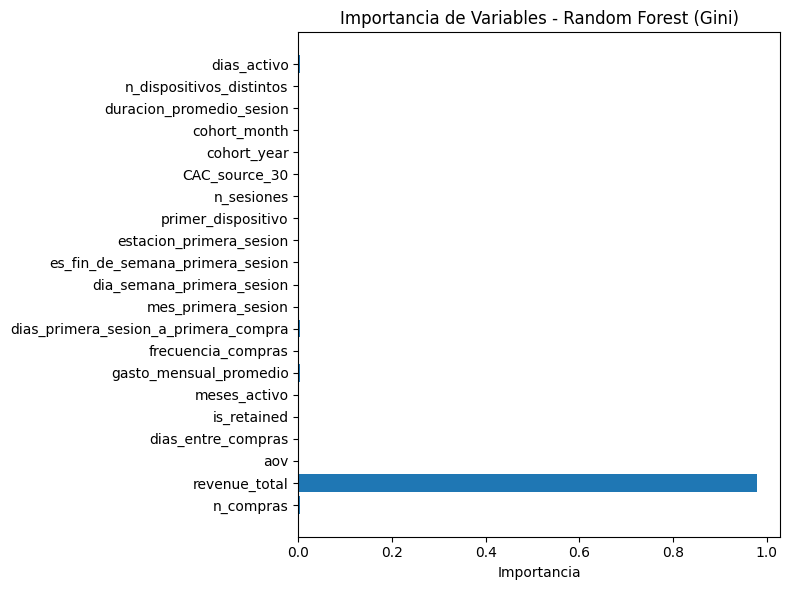

In [35]:
plt.figure(figsize=(8, 6))
plt.barh(input_features, importancias)
plt.title('Importancia de Variables - Random Forest (Gini)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()